# Imports

In [6]:
from dqn_agent import DQNAgent
from ppo_agent import PPOAgent
from ffnn_agent import FFNNAgent
from data_processing import preprocess_all_data, load_preprocessed_dataset, get_activity, get_column_units, get_xy_from_data
from visualize import visualize_results, visualize_training, visualize_preprocessed_data
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load Data

In [7]:
# Load the preprocessed dataset
df = load_preprocessed_dataset()
target_features = ["Resting HR", "Max HR", "Age", "Weight", "Height"]

# Print unique values of target features
for feature in target_features:
    print(f"'{feature}' unique values: {df[feature].unique()}")

# Print unique values of 'Age'
print(f"\nUnique values of 'Age': {df['Age'].unique()}")

# Print how many rows there are for Activity ID 1 and 2
activity_counts = df['Activity ID'].value_counts()
print("\nActivity ID counts:")
for act_id in [1, 2]:
    count = activity_counts.get(act_id, 0)
    print(f"Activity ID {act_id}: {count} rows")

# Split based on Activity ID
df_val = df[df['Activity ID'] == 1].copy()
df_test = df[df['Activity ID'] == 2].copy()
df_train = df[~df['Activity ID'].isin([1, 2])].copy()

# Shuffle train set (optional but recommended)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Report split sizes
print(f"\nTrain samples (excluding Activity 1 & 2): {df_train.shape[0]}")
print(f"Validation samples (Activity 1): {df_val.shape[0]}")
print(f"Test samples (Activity 2): {df_test.shape[0]}")

# Get X and y splits
x_train, y_train = get_xy_from_data(df_train, target_features)
x_val, y_val = get_xy_from_data(df_val, target_features)
x_test, y_test = get_xy_from_data(df_test, target_features)

# Sanity check
print(f"\nX_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {x_test.shape}, y_test: {y_test.shape}")


---- Preprocessed Dataset Info ----
Number of rows: 61000
Number of columns: 39
-----------------------------------
'Resting HR' unique values: [75 74 68 58 70 60]
'Max HR' unique values: [193 195 189 196 194 197]
'Age' unique values: [27 25 31 24 26 23]
'Weight' unique values: [83 78 92 95 73 69 86]
'Height' unique values: [182 169 187 194 180 183 173]

Unique values of 'Age': [27 25 31 24 26 23]

Activity ID counts:
Activity ID 1: 7000 rows
Activity ID 2: 7000 rows

Train samples (excluding Activity 1 & 2): 47000
Validation samples (Activity 1): 7000
Test samples (Activity 2): 7000

X_train: (47000, 34), y_train: (47000, 5)
X_val: (7000, 34), y_val: (7000, 5)
X_test: (7000, 34), y_test: (7000, 5)


# Initialize system

In [8]:
continuous_columns = [
    'Timestamp',  'Hand Sensor - Temperature',
    'Hand Sensor - Accelerometer - X', 'Hand Sensor - Accelerometer - Y',
    'Hand Sensor - Accelerometer - Z', 'Hand Sensor - Gyroscope - X',
    'Hand Sensor - Gyroscope - Y', 'Hand Sensor - Gyroscope - Z',
    'Hand Sensor - Magnetometer - X', 'Hand Sensor - Magnetometer - Y',
    'Hand Sensor - Magnetometer - Z', 'Chest Sensor - Temperature',
    'Chest Sensor - Accelerometer - X', 'Chest Sensor - Accelerometer - Y',
    'Chest Sensor - Accelerometer - Z', 'Chest Sensor - Gyroscope - X',
    'Chest Sensor - Gyroscope - Y', 'Chest Sensor - Gyroscope - Z',
    'Chest Sensor - Magnetometer - X', 'Chest Sensor - Magnetometer - Y',
    'Chest Sensor - Magnetometer - Z', 'Ankle Sensor - Temperature',
    'Ankle Sensor - Accelerometer - X', 'Ankle Sensor - Accelerometer - Y',
    'Ankle Sensor - Accelerometer - Z', 'Ankle Sensor - Gyroscope - X',
    'Ankle Sensor - Gyroscope - Y', 'Ankle Sensor - Gyroscope - Z',
    'Ankle Sensor - Magnetometer - X', 'Ankle Sensor - Magnetometer - Y',
    'Ankle Sensor - Magnetometer - Z'
]

discrete_columns = [
     'Sex - Female', 'Heart Rate', "Resting HR", "Max HR", "Weight", "Height"
]

#discrete action size columns
dqn_config = {
    'state_size': 5,  
    'action_size': len(discrete_columns),  
    'hidden_size': 64,
    'lr': 1e-3,
    'gamma': 0.9995,
    'batch_size': 64,
    'memory_size': 10000,
    'epsilon_start': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.995
}


#continuous
ppo_config = {
    'state_size': 5,  
    'action_size': len(continuous_columns),   
    'hidden_size': 64,
    'lr': 1e-3,
    'gamma': 0.9995,
    'clip_epsilon': 0.2,
    'update_epochs': 10,
    'batch_size': 64,
    'c1': 0.5,
    'c2': 0.01
}
classes = [1, 2, 3, 17, 16, 13, 4, 7, 6]

ffnn_config = {
    'input_size': df.shape[1] - 5,
    'hidden_sizes': [16, 16],
    'output_size': 5,
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 1,
    'type': 'regression',
    'classes': None
}

accuracy_reward_multiplier = 10

synthetic_data_amount = 1000
num_episodes = 100

dqn_agent = DQNAgent(**dqn_config)
ppo_agent = PPOAgent(**ppo_config)
ffnn_agent = FFNNAgent(**ffnn_config)
ffnn_agent_og = FFNNAgent(**ffnn_config)

Using device: cuda
Using device: cuda


# Training


Training FFNN on real data only (no synthetic data)...


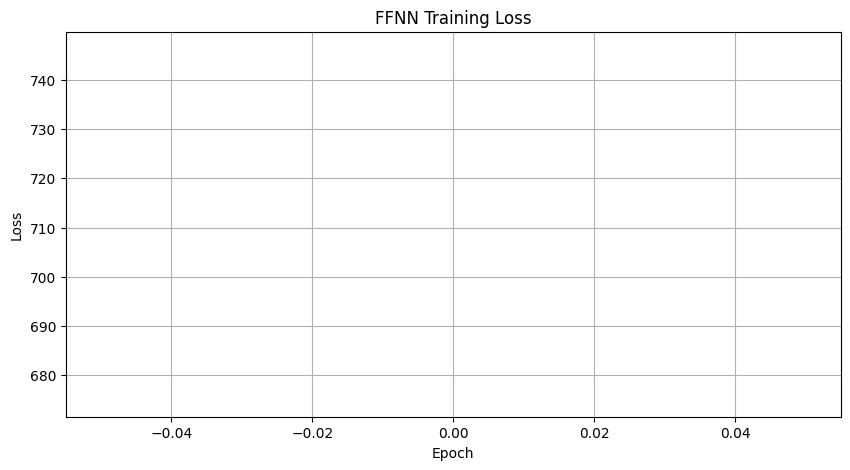


========== FFNN Baseline (No Synthetic Data) ==========
Train MSE: 64.5062 | Train MAE: 6.1899 | Female MSE: 54.1787
Val   MSE: 361.9044 | Val   MAE: 15.0752 | Female MSE: 154.9865
Test  MSE: 157.8940 | Test  MAE: 9.7839 | Female MSE: 52.6009

Baseline Results: {'train': (64.50624084472656, 6.189897060394287), 'val': (361.9043884277344, 15.075185775756836), 'test': (157.89395141601562, 9.78392219543457)}
Episode 1/100: Generating Synthetic Data


In [ ]:
def evaluate_ffnn(ffnn_agent, data, labels):
    if isinstance(data, (pd.DataFrame, pd.Series)):
        data = data.to_numpy()
    if isinstance(labels, (pd.DataFrame, pd.Series)):
        labels = labels.to_numpy()

    predictions = ffnn_agent.predict(data)

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()

    mse = mean_squared_error(labels, predictions)
    mae = mean_absolute_error(labels, predictions)

    # Optional: female-specific evaluation
    female_mask = data[:, -1] == 1
    if female_mask.sum() > 0:
        female_preds = predictions[female_mask]
        female_labels = labels[female_mask]
        female_mse = mean_squared_error(female_labels, female_preds)
    else:
        female_mse = float('nan')

    return mse, mae, female_mse



def plot_ffnn_losses(losses):
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('FFNN Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # ages in df = [27, 25, 31, 24, 26, 23]

def generate_state(df, mf_ratio, n_samples):
    timestamp = np.random.uniform(df['Timestamp'].min(), df['Timestamp'].max())
    male_female_ratio = mf_ratio 
    num_samples = n_samples
    age = np.random.uniform(24, 31)
    activity_id = np.random.choice([1, 2, 3, 17, 16, 13, 4, 7, 6])
    return np.array([timestamp, male_female_ratio, num_samples, age, activity_id])


def compute_mini_reward(synthetic_data, mf_ratio):
    column_std = np.std(synthetic_data, axis=0).mean()
    gaussian_penalty = np.exp(-((mf_ratio - 0.5) ** 2) / 0.1)
    return column_std + gaussian_penalty


def train_ffnn_baseline(ffnn_agent, x_train, y_train, x_val, y_val, x_test, y_test):
    # Train on real data only
    print("\nTraining FFNN on real data only (no synthetic data)...")
    losses = ffnn_agent.train(x_train.to_numpy(), y_train.to_numpy())
    plot_ffnn_losses(losses)

    # Evaluate on all splits
    train_mse, train_mae, train_female_mse = evaluate_ffnn(ffnn_agent, x_train, y_train)
    val_mse, val_mae, val_female_mse = evaluate_ffnn(ffnn_agent, x_val, y_val)
    test_mse, test_mae, test_female_mse = evaluate_ffnn(ffnn_agent, x_test, y_test)

    # Print results
    print("\n========== FFNN Baseline (No Synthetic Data) ==========")
    print(f"Train MSE: {train_mse:.4f} | Train MAE: {train_mae:.4f} | Female MSE: {train_female_mse:.4f}")
    print(f"Val   MSE: {val_mse:.4f} | Val   MAE: {val_mae:.4f} | Female MSE: {val_female_mse:.4f}")
    print(f"Test  MSE: {test_mse:.4f} | Test  MAE: {test_mae:.4f} | Female MSE: {test_female_mse:.4f}")
    print("=======================================================\n")

    return {
        "train": (train_mse, train_mae),
        "val": (val_mse, val_mae),
        "test": (test_mse, test_mae),
    }

baseline_results = train_ffnn_baseline(ffnn_agent_og, x_train, y_train, x_val, y_val, x_test, y_test)

def train_agents(x_train, y_train, x_val, y_val, x_test, y_test,
                 dqn_agent, ppo_agent, ffnn_agent, episodes=num_episodes,
                 save_path='training_metrics.json'):

    # Normalize y arrays to shape (n, 1)
    # for var in ['y_train', 'y_val', 'y_test']:
    #     val = locals()[var]
    #     if isinstance(val, pd.Series):
    #         locals()[var] = val.to_numpy().reshape(-1, 1)
    #     elif isinstance(val, pd.DataFrame):
    #         locals()[var] = val.to_numpy()

    rewards = []
    val_accuracies = []
    test_accuracies = []
    train_accuracies = []
    val_female_accuracies = []
    test_female_accuracies = []
    train_female_accuracies = []

    synthetic_data = []
    synthetic_labels = []

    # Initial male-female ratio
    sex_female_idx = x_train.columns.get_loc('Sex - Female')
    mf_ratio = np.mean(x_train.iloc[:, sex_female_idx])
    state = generate_state(x_train, mf_ratio, 0)






    for episode in range(episodes):
        print(f"Episode {episode + 1}/{episodes}: Generating Synthetic Data")
        for i in range(synthetic_data_amount):
            if synthetic_data:
                synthetic_array = np.array(synthetic_data)
                if synthetic_array.ndim == 1:
                    synthetic_array = synthetic_array.reshape(1, -1)
                combined_array = np.vstack([x_train.to_numpy(), synthetic_array])
                combined = pd.DataFrame(combined_array, columns=x_train.columns)
            else:
                combined = x_train.copy()

            sex_female_idx = combined.columns.get_loc('Sex - Female')
            mf_ratio = np.mean(combined.iloc[:, sex_female_idx])

            # Predict actions from RL agents
            discrete_action = np.array(dqn_agent.predict(state), ndmin=1).flatten()

            # First 2 values are features: 'Sex - Female', 'Heart Rate'
            sex_value = discrete_action[0]
            heart_rate = discrete_action[1]

            # Predicted target values: Resting HR, Max HR, Weight, Height (4 values)
            predicted_targets = discrete_action[2:6]

            # Age comes from the state (4th element)
            age_from_state = state[3]

            # Combine into full target: [Resting HR, Max HR, Age, Weight, Height]
            target_values = np.insert(predicted_targets, 2, age_from_state)  # insert age at index 2
            # Resulting shape: (5,) — matches label format

            # Predict continuous features
            continuous_action = np.array(ppo_agent.predict(state), ndmin=1)  # shape (1, num_continuous_features)

            # Create synthetic feature row
            synthetic_row = np.zeros(x_train.shape[1])

            # Get column indices
            discrete_indices = x_train.columns.get_indexer(['Sex - Female', 'Heart Rate'])
            continuous_indices = x_train.columns.get_indexer(continuous_columns)

            # Assign values to synthetic row
            synthetic_row[discrete_indices[0]] = sex_value
            synthetic_row[discrete_indices[1]] = heart_rate
            synthetic_row[continuous_indices] = continuous_action.flatten()

            # Add to synthetic dataset
            synthetic_data.append(synthetic_row)
            synthetic_labels.append(target_values)

            mini_reward = compute_mini_reward(np.array(synthetic_data), mf_ratio)
            done = i == synthetic_data_amount - 1


            if done:
                print(f"Episode {episode + 1}/{episodes}: Training FFNN")
                
                ffnn_agent.reset()

                synthetic_data_np = np.array(synthetic_data)                    # (n_samples, num_features)
                synthetic_labels_np = np.array(synthetic_labels).reshape(-1, 5) # (n_samples, 5)

                combined_data = np.vstack([x_train.to_numpy(), synthetic_data_np])
                combined_labels = np.vstack([y_train, synthetic_labels_np])


                # Shuffle combined training data
                indices = np.arange(combined_data.shape[0])
                np.random.shuffle(indices)
                combined_data = combined_data[indices]
                combined_labels = combined_labels[indices]

                # Train FFNN
                losses = ffnn_agent.train(combined_data, combined_labels)
                plot_ffnn_losses(losses)

                print(f"Episode {episode + 1}/{episodes}: Evaluating FFNN")

                train_mse, train_mae, train_female_mse = evaluate_ffnn(ffnn_agent, x_train, y_train)
                val_mse, val_mae, val_female_mse = evaluate_ffnn(ffnn_agent, x_val, y_val)
                test_mse, test_mae, test_female_mse = evaluate_ffnn(ffnn_agent, x_test, y_test)

                # Reward is based on validation performance and mini reward
                reward = (accuracy_reward_multiplier * val_mse * -1) + (mini_reward)

                train_accuracies.append(train_mse)
                val_accuracies.append(val_mse)
                test_accuracies.append(test_mse)
                train_female_accuracies.append(train_female_mse)
                val_female_accuracies.append(val_female_mse)
                test_female_accuracies.append(test_female_mse)

                print(f"Episode {episode + 1}/{episodes} | Reward: {reward:.4f}")
                print(f"Train MSE: {train_mse:.4f} | Train Female MSE: {train_female_mse:.4f}")
                print(f"Val MSE: {val_mse:.4f} | Val Female MSE: {val_female_mse:.4f}")
                print(f"Test MSE: {test_mse:.4f} | Test Female MSE: {test_female_mse:.4f}")
                print("\n--------------------------------\n")


                synthetic_data = []
                synthetic_labels = []
            else:
                reward = mini_reward

            next_state = generate_state(x_train, mf_ratio, len(synthetic_data) + 1)
            dqn_agent.learn(state, discrete_action, reward, next_state, done)
            ppo_agent.learn(state, continuous_action, reward, next_state, done)

            rewards.append(reward)
            state = next_state

        metrics = {
            'rewards': rewards,
            'train_mse': train_accuracies,
            'val_mse': val_accuracies,
            'test_mse': test_accuracies,
            'train_female_mse': train_female_accuracies,
            'val_female_mse': val_female_accuracies,
            'test_female_mse': test_female_accuracies
        }


    with open(save_path, 'w') as f:
        json.dump(metrics, f)
    print(f"Metrics saved to {save_path}")

    return metrics

# Example usage
results = train_agents(x_train, y_train, x_val, y_val, x_test, y_test, dqn_agent, ppo_agent, ffnn_agent)
dqn_agent.save("dqn_trained_model.pth")
ppo_agent.save("ppo_trained_model.pth")


# Testing


In [ ]:

accuracy = evaluate_ffnn(ffnn_agent, x_test, y_test)
print(f"Test Results | Accuracy: {accuracy:.4f}")





# Visualize results

In [6]:
# visualize_training([], [])
# visualize_results(dqn_agent, ppo_agent, df)
# visualize_preprocessed_data(df)